In [1]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [2]:
NOTE = 'LightGBM特徴量ミニマム（カテゴリ変数指定）'
notebook_name = '055'

N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

055_submission.csv 055


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  vector_features=None,
                  features=None) -> Pipeline:

    clf = LGBMClassifier(random_state=SEED,
                         class_weight='balanced',
                         importance_type='gain',
                         n_jobs=-1,
                         n_estimators=300,
                         learning_rate=0.01)
    return Pipeline(
        steps=[
            ('estimator', clf)
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
CATEGORICAL_FEATURES

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
discrete_features = list(set(minimal_features) - set(categorical_features))
print(categorical_features)
print(discrete_features)

# Execute if categories should be one-hot style
# for c in categorical_features:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])

# train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
# test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

# categorical_features_1hot = []
# for c in categorical_features:
#     categorical_features_1hot += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
# print(categorical_features_1hot)

# features = discrete_features + categorical_features_1hot
features = discrete_features + categorical_features

['b1', 'b2', 'b3', 'batterID', 'pitcherID', 'Match', 'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher', 'isBottom', 'batterTeam', 'pitcherTeam']
['inningNo', 'S', 'numRunners', 'B', 'O', 'totalPitchingCount']


In [7]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )

    clf = get_estimator(features=features,
                        discrete_features=discrete_features,
                        categorical_features=categorical_features)
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    clf.fit(X_train,
            y_train.values,
            estimator__sample_weight=sample_weight,
            estimator__categorical_feature=categorical_features)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 1)**********
[[1950  916  633  630  515  257    9  156]
 [ 458 1947  401  373  307  152   10   98]
 [ 244  266 1103  315  283  113    5   64]
 [ 125  149  130 1065  152   53    1   34]
 [   2    3    1    0  530    4    0    0]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    8    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 1)**********
[[296 295 219 186 159  65   5  42]
 [168 303 140 142  93  51   3  36]
 [113 106 134 103  87  33   0  23]
 [ 71  67 109  92  45  27   3  13]
 [ 28  29  26  26  20   5   0   1]
 [ 13   5   5   7   2   4   0   1]
 [  2   0   0   1   0   0   0   0]
 [  6   6   6   3   3   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 2)**********
[[1929  922  666  601  531  266   15  136]
 [ 482 1914  394  349  317  180   11   99]
 [ 239  289 1106  324  265  107    7   56]
 [ 139  163  152 1014  140   63    5   33]
 [   4    2    1    2  527    3    0    1]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 2)**********
[[294 310 202 190 146  73   6  46]
 [211 310 135 115 105  33   2  25]
 [ 92 123 113 141  77  30   1  22]
 [ 69  95 100  99  42  15   2   5]
 [ 23  25  42  22  15   3   0   5]
 [  8  10   8   5   3   3   0   0]
 [  0   1   1   0   0   0   0   0]
 [  8   5   5   2   3   1   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 3)**********
[[1938  961  657  589  519  234   10  158]
 [ 445 1975  400  374  302  146    5   99]
 [ 251  281 1094  326  264  106    4   68]
 [ 137  162  148 1057  132   46    3   23]
 [   2    2    3    2  529    2    0    0]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 3)**********
[[325 321 196 162 145  65   8  45]
 [231 304 125 117  81  46   4  28]
 [106 109 124 133  72  28   2  24]
 [ 94  81  85  95  44  19   0  10]
 [ 29  28  22  28  18   4   0   6]
 [  8  12   5   9   2   1   0   0]
 [  1   0   0   0   0   1   0   0]
 [  4   4   7   4   2   2   0   1]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 4)**********
[[1920  933  644  634  545  239    9  143]
 [ 479 1932  388  383  315  158    9   81]
 [ 242  300 1089  337  258   99    3   66]
 [ 138  154  131 1069  130   57    3   27]
 [   3    0    0    0  536    1    0    0]
 [   0    0    0    0    0  149    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 4)**********
[[306 309 198 194 149  70   1  39]
 [184 318 134 137  91  36   3  34]
 [ 98 124 130 116  94  26   1   9]
 [ 78  82  98  79  62  15   1  12]
 [ 29  22  28  30  13   9   1   3]
 [  9   7   5  10   4   3   0   0]
 [  1   1   0   0   0   0   0   0]
 [  5   8   7   0   3   0   0   1]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 5)**********
[[1940  934  647  589  514  258   14  171]
 [ 452 1955  401  366  304  156   13   98]
 [ 252  306 1087  297  274  110    6   62]
 [ 141  147  156 1028  140   60    4   33]
 [   2    2    1    0  533    2    0    0]
 [   0    0    0    0    0  149    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 5)**********
[[289 335 194 180 145  80   1  42]
 [196 315 112 130 105  51   2  26]
 [110 114 104 132  82  31   1  24]
 [ 70  95  95  85  52  18   4   8]
 [ 27  22  23  35  17   6   0   5]
 [  5  13   5   5   7   2   0   1]
 [  0   1   0   1   0   0   0   0]
 [  4   8   4   4   3   0   0   1]]

Wall time: 59.8 s


In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.446761,0.141209
std,0.010133,0.003983
min,0.435635,0.135613
25%,0.437138,0.139116
50%,0.448138,0.141458
75%,0.454909,0.144759
max,0.457987,0.145097


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,0,0,1
1,1,1,0,0,1
2,2,0,0,0,1
3,3,2,2,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,2,0,5
17130,16833,1,1,0,5
17133,9762,1,2,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.140495,0.107975,0.265511,0.082335,0.323779,0.012886,0.056791,0.010228,27446,1
1,0.079238,0.050759,0.688905,0.130890,0.019260,0.005369,0.020856,0.004724,113,1
2,0.109901,0.196967,0.577175,0.064173,0.008312,0.004463,0.035007,0.004002,4479,1
3,0.109755,0.150606,0.587453,0.128057,0.010149,0.005231,0.004092,0.004658,29080,1
4,0.299903,0.165973,0.263018,0.213274,0.032072,0.010588,0.007041,0.008132,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.111128,0.528993,0.143079,0.185330,0.012964,0.006420,0.005733,0.006353,24272,5
33804,0.098433,0.146877,0.278551,0.426604,0.022503,0.009395,0.008372,0.009266,29106,5
33805,0.093672,0.134552,0.303367,0.415507,0.025110,0.009577,0.008675,0.009540,20679,5
33806,0.403582,0.129521,0.188192,0.240189,0.017942,0.007119,0.006401,0.007055,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.986528,1.241001,1.218264,1.028815,0.327347,0.077014,0.054875,0.066156
1,1,1.412550,1.772576,0.744339,0.768802,0.109604,0.108653,0.040030,0.043446
2,2,0.504165,0.448396,0.934368,1.621787,1.237073,0.116204,0.049979,0.088028
3,3,1.469096,2.513839,0.409087,0.451210,0.077094,0.028275,0.024599,0.026801
4,4,0.973800,1.642364,0.252996,0.421320,1.643760,0.024358,0.018961,0.022441
...,...,...,...,...,...,...,...,...,...
33803,33803,2.320597,0.572142,0.749985,0.739756,0.423146,0.066853,0.049428,0.078093
33804,33804,1.580685,1.266333,0.821197,0.966134,0.254319,0.041366,0.033047,0.036919
33805,33805,2.471846,1.220516,0.338859,0.751979,0.100980,0.044127,0.034685,0.037009
33806,33806,0.687154,1.025645,1.106001,0.949163,0.932773,0.128218,0.081592,0.089454


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,3
3,3,1
4,4,4
...,...,...
33803,33803,0
33804,33804,0
33805,33805,0
33806,33806,2


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.280437
1    0.403248
2    0.070930
3    0.191523
4    0.033010
5    0.012541
6    0.000858
7    0.007454
Name: y, dtype: float64

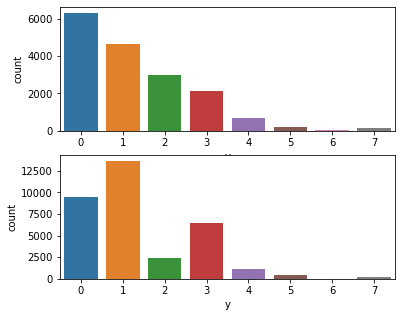

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.4467612578103009, 0.14120878101412995)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"055_submission.csv","Stratified-Kfold(K=5)","0.446761","0.141209","","LightGBM特徴量ミニマム（カテゴリ変数指定）"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 2 s


In [20]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 19.5 ms


In [21]:
imp_df

,feature,importance,fold
0,inningNo,79993.884129,1
1,S,44556.551558,1
2,numRunners,21323.016560,1
3,B,39308.718924,1
4,O,47194.142003,1
...,...,...,...
13,isPitcherHandLeft,7005.779984,5
14,isBatterPitcher,3917.027591,5
15,isBottom,5787.503123,5
16,batterTeam,200.031040,5


In [22]:
%%time
coef_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [23]:
coef_df

""
